In [1]:
from graphviz import Digraph 

In [8]:
import numpy as np 
import math

In [4]:
# import torch

In [5]:
# torch.cuda.is_available()

In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [29]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data 
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"

    def __add__(self, other): 
        # self, other 这两个子结点, 产生父结点 out
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out 

    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): 
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 

        out._backward = _backward
        return out 

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): 
            self.grad += (1 - t**2) * out.grad 
        
        out._backward = _backward
        return out 

    def backward(self): 
        topo = [] 
        visited = set()

        def build_topo(v): 
            if v not in visited: 
                visited.add(v) 
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0 

        for node in reversed(topo): 
            node._backward()

In [16]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

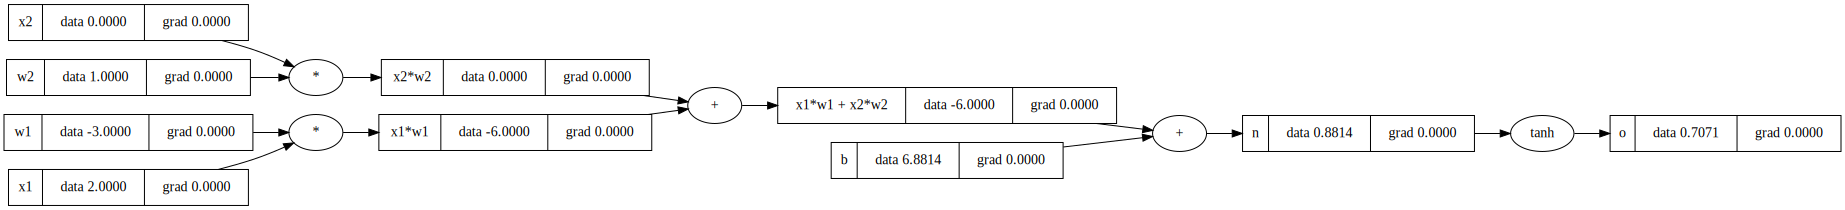

In [17]:
draw_dot(o)

In [18]:
o.backward()

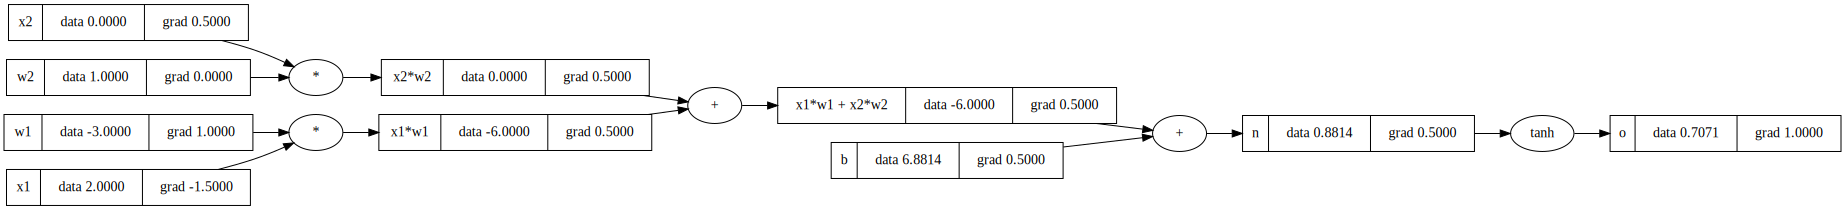

In [19]:
draw_dot(o)

### 处理特殊情况

In [30]:
x = Value(3.0); a.label = 'x'
y = Value(2.);  y.label = 'y'

In [31]:
x 

Value(data=3.0)

In [32]:
x.__add__(y)

Value(data=5.0)

In [33]:
# 通过将2 即(ohter)包装为一个Value来解决这个问题
x.__add__(2)

Value(data=5.0)

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[27], line 1
----> 1 x.__add__(2)

Cell In[15], line 15, in Value.__add__(self, other)
     13 def __add__(self, other): 
     14     # self, other 这两个子结点, 产生父结点 out
---> 15     out = Value(self.data + other.data, (self, other), '+')
     17     def _backward(): 
     18         self.grad += 1.0 * out.grad

AttributeError: 'int' object has no attribute 'data'
```

In [34]:
# 同理
x * 2

Value(data=6.0)

In [35]:
2 * x 

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[35], line 1
----> 1 2 * x 

TypeError: unsupported operand type(s) for *: 'int' and 'Value'
``` 